In [2]:
%load_ext autoreload
%autoreload 2
from evaluation.face_recognition_test import Face_Fecognition_test
from evaluation.ijb_evals import instantiate_list
from omegaconf import OmegaConf
from pathlib import Path
import numpy as np
from evaluation.visualize import (
    plot_dir_far_scores,
    plot_cmc_scores,
    plot_rejection_scores,
)
from evaluation.confidence_functions import MisesProb
from hydra.utils import instantiate

In [3]:
cfg = OmegaConf.load("/app/configs/uncertainty_benchmark/ijb_evals.yaml")
method = cfg.open_set_identification_methods[0]
sampler = instantiate(method.sampler)
evaluation_function = instantiate(method.evaluation_function)
assert evaluation_function is not None
# if cfg.test_dataset.dataset_name == "survFace" and method.use_detector_score:
#     continue
template_pooling = instantiate(method.template_pooling_strategy)

In [4]:
open_set_identification_metrics = instantiate_list(cfg.open_set_identification_metrics)
if "open_set_uncertainty_metrics" in cfg:
    open_set_uncertainty_metrics = instantiate_list(cfg.open_set_uncertainty_metrics)
else:
    open_set_uncertainty_metrics = []

test_dataset = instantiate(cfg.test_dataset)

# create result dirs:
dataset_name = cfg.test_dataset.dataset_name
open_set_identification_result_dir = (
    Path(cfg.exp_dir) / dataset_name / "open_set_identification"
)
open_set_identification_result_dir.mkdir(exist_ok=True, parents=True)

tt = Face_Fecognition_test(
    sampler=sampler,
    evaluation_function=evaluation_function,
    test_dataset=test_dataset,
    embeddings_path=method.embeddings_path,
    template_pooling_strategy=template_pooling,
    use_detector_score=method.use_detector_score,
    use_two_galleries=cfg.use_two_galleries,
    recompute_template_pooling=cfg.recompute_template_pooling,
    open_set_identification_metrics=open_set_identification_metrics,
    closed_set_identification_metrics=None,
    verification_metrics=None,
    open_set_uncertainty_metrics=open_set_uncertainty_metrics,
)

In [5]:
(
    g1_templates_feature,
    g1_template_unc,
    g1_unique_ids,
) = tt.get_template_subsets(tt.test_dataset.g1_templates, tt.test_dataset.g1_ids)

(
    probe_templates_feature,
    probe_template_unc,
    probe_unique_ids,
) = tt.get_template_subsets(tt.test_dataset.probe_templates, tt.test_dataset.probe_ids)

# sample probe feature vectors

probe_templates_feature = tt.sampler(
    probe_templates_feature,
    probe_template_unc,
)

In [6]:
similarity, probe_score = tt.evaluation_function(
    probe_templates_feature,
    probe_template_unc,
    g1_templates_feature,
    g1_template_unc,
)

In [7]:
similarity.shape

(19593, 1, 1772)

In [8]:
gallery_ids = g1_unique_ids
gallery_ids_argsort = np.argsort(gallery_ids)
gallery_ids_sorted = gallery_ids[gallery_ids_argsort]

In [12]:
gallery_ids_sorted_von_mises = np.concatenate([gallery_ids_sorted, [-1]]) # last id is for out of gallery

def compute_von_Mises_tar_far(kappa, beta, probe_ids, gallery_ids_sorted_von_mises, gallery_ids_argsort, similarity, present_probe_ids):
    selected_probe_ids = probe_ids[present_probe_ids]
    selected_similarity = similarity[present_probe_ids]
    is_seen = np.isin(selected_probe_ids, gallery_ids)
    seen_probe_ids = selected_probe_ids[is_seen]
    mises_maxprob = MisesProb(kappa=kappa, beta=beta)
    all_classes_log_prob = mises_maxprob.compute_all_class_log_probabilities(
                selected_similarity
            )
    all_classes_log_prob = all_classes_log_prob[:, 0, :]

    # make pred
    # sort labels
    all_classes_log_prob[:, :-1] = all_classes_log_prob[:, :-1][:, gallery_ids_argsort]
    predict_id = np.argmax(all_classes_log_prob, axis=-1)
    # far
    far = np.mean(predict_id[~is_seen]!=similarity.shape[-1])
    # tar
    tar = np.mean(gallery_ids_sorted_von_mises[predict_id[is_seen]] == seen_probe_ids)
    return tar, far
    

In [13]:
from itertools import product
from tqdm import tqdm
kappas = np.linspace(100,1200,6)
betas = np.logspace(-0.01, -0.01, num=1)
print(len(kappas) * len(betas))
kappa_beta_to_tar_far = {}
present_probe_ids = np.arange(probe_unique_ids.shape[0])
for kappa, beta in tqdm(product(kappas, betas), total=len(kappas) * len(betas)):
    tar, far = compute_von_Mises_tar_far(kappa, beta, probe_unique_ids, gallery_ids_sorted_von_mises, gallery_ids_argsort, similarity, present_probe_ids)
    #print(f'tar-{tar} at far-{far} with kappa-{kappa} and beta {beta}')
    kappa_beta_to_tar_far[(kappa, beta)] = (tar, far)

  0%|          | 0/6 [00:00<?, ?it/s]

6


100%|██████████| 6/6 [00:18<00:00,  3.07s/it]


In [14]:
kappa_beta_to_tar_far

{(100.0, 0.9772372209558107): (0.9720785935884177, 0.9766199737982465),
 (320.0, 0.9772372209558107): (0.9667011375387797, 0.20366824549027512),
 (540.0, 0.9772372209558107): (0.9445708376421923, 0.010178373475763378),
 (760.0, 0.9772372209558107): (0.8840744570837642, 0.0019147435251436057),
 (980.0, 0.9772372209558107): (0.2108583247156153, 0.0014108636501058147),
 (1200.0, 0.9772372209558107): (0.0006204756980351603, 0.001007759750075582)}

In [15]:
tars = np.array([kappa_beta_to_tar_far[key][0] for key in kappa_beta_to_tar_far])
fars = np.array([kappa_beta_to_tar_far[key][1] for key in kappa_beta_to_tar_far])

far_sort_idx = np.argsort(fars)
fars = fars[far_sort_idx]
tars = tars[far_sort_idx]

In [16]:
a = np.load('/app/outputs/experiments/open_set_uncertainty_without_thresh/IJBC/open_set_identification/Cosine_recalls_1_rank.npz')

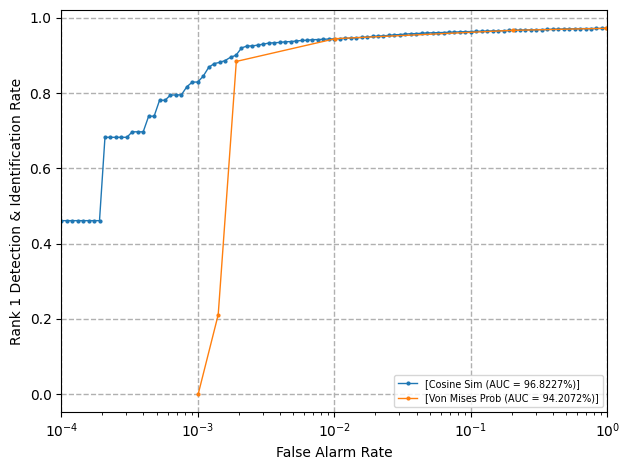

In [17]:
scores = [(a['fars'], a['recalls']) , (fars, tars)]
model_names = ['Cosine Sim', 'Von Mises Prob']
fig = plot_dir_far_scores(
            scores=scores,
            names=model_names,
            y_label=f"Rank 1 Detection & Identification Rate",
            marker='o'
        )
fig.savefig(f"dir_plot.png", dpi=300)

### Perform rejection based on uncertanty for a fixed algorithm (fixed threshold or kappa)

First we fix parametr of algorithm, so it have far=0.01

In [40]:
kappa = 540.0
beta = 0.9772372209558107

In [18]:
cosine_far = 0.010178373475763378 # far of von Mises at kappa = 540.0, beta = 0.9772372209558107
# compute operating threshold τ, which gives neaded far
is_seen = np.isin(probe_unique_ids, gallery_ids)
neg_score = probe_score[~is_seen]
pos_score = probe_score[is_seen]
neg_score_sorted = np.sort(neg_score)[::-1]
if len(neg_score_sorted) == 0:
    thresh = -np.inf
else:
    thresh = neg_score_sorted[
        max(int((neg_score_sorted.shape[0]) * cosine_far) - 1, 0)
    ]

In [19]:
thresh

0.4121742600157263

In [20]:
def compute_cosine_tar_far(thresh, probe_ids, gallery_ids, probe_score, similarity, present_probe_ids, rank=1):
    selected_probe_ids = probe_ids[present_probe_ids]
    selected_probe_scores = probe_score[present_probe_ids]
    selected_similarity = similarity[present_probe_ids]
    is_seen = np.isin(selected_probe_ids, gallery_ids)
    seen_sim: np.ndarray = selected_similarity[is_seen]
    neg_score = selected_probe_scores[~is_seen]
    pos_score = selected_probe_scores[is_seen]
    seen_probe_ids = selected_probe_ids[is_seen]
    most_similar_classes = np.argmax(seen_sim, axis=1)
    similar_class = gallery_ids[most_similar_classes]
    correct_pos = seen_probe_ids == similar_class
    tar = (
            np.sum(np.logical_and(correct_pos, pos_score > thresh))
            / seen_probe_ids.shape[0]
        )
    far = np.mean(neg_score>thresh)
    return tar, far
    

In [21]:
similarity_sorted = similarity[:,0, gallery_ids_argsort]
present_probe_ids = np.arange(probe_unique_ids.shape[0])
compute_cosine_tar_far(thresh, probe_unique_ids, gallery_ids_sorted, probe_score, similarity_sorted, present_probe_ids)

(0.944364012409514, 0.01007759750075582)

In [37]:
similarity[0]

array([[ 0.69581817, -0.06561534,  0.02471318, ...,  0.03592767,
        -0.01968774, -0.02620966]])

In [41]:
mises_maxprob = MisesProb(kappa=kappa, beta=beta)
all_classes_log_prob = mises_maxprob.compute_all_class_log_probabilities(
            similarity
        )
all_classes_log_prob = all_classes_log_prob[:, 0, :]
prob_unc = -np.max(all_classes_log_prob, axis=1)

In [47]:
# import seaborn as sns
# sns.distplot(
#     prob_unc[prob_unc > 0.0000847964190705177],
#     kde=True,
#     norm_hist=True,
#     hist=True,
#     label='maxprob',
# )

In [50]:
fractions = np.arange(0, 0.55, 0.05)
probe_sorted_by_scf_unc = np.argsort(-probe_template_unc[:,0])
probe_sorted_by_prob_unc = np.argsort(prob_unc)
scf_rejection_tar_far = {}
probe_rejection_tar_far = {}
for fraction in tqdm(fractions):
    good_probes_idx_scf = probe_sorted_by_scf_unc[: int((1 - fraction) * probe_unique_ids.shape[0])]
    good_probes_idx_prob = probe_sorted_by_prob_unc[: int((1 - fraction) * probe_unique_ids.shape[0])]
    scf_tar, scf_far = compute_cosine_tar_far(thresh, probe_unique_ids, gallery_ids_sorted, probe_score, similarity_sorted, good_probes_idx_scf)
    scf_rejection_tar_far[fraction] = (scf_tar, scf_far)
    probe_tar, probe_far = compute_von_Mises_tar_far(kappa, beta, probe_unique_ids, gallery_ids_sorted_von_mises, gallery_ids_argsort, similarity, good_probes_idx_prob)
    probe_rejection_tar_far[fraction] = (probe_tar, probe_far)

100%|██████████| 11/11 [00:32<00:00,  2.91s/it]


In [51]:
scf_rejection_tar_far

{0.0: (0.944364012409514, 0.01007759750075582),
 0.05: (0.9636480963648096, 0.009769189479334407),
 0.1: (0.9692583866262763, 0.009977064220183487),
 0.15000000000000002: (0.9724932408604678, 0.009819565484227324),
 0.2: (0.9742420507764358, 0.010052910052910053),
 0.25: (0.9760665972944849, 0.00984870111333143),
 0.30000000000000004: (0.9773793103448276, 0.009899458623356535),
 0.35000000000000003: (0.9790992051810421, 0.0100993098804915),
 0.4: (0.9797211660329531, 0.00973727723681793),
 0.45: (0.9805875279161657, 0.010090817356205853),
 0.5: (0.980506091846298, 0.009863259358888142)}

In [52]:
probe_rejection_tar_far

{0.0: (0.9445708376421923, 0.010178373475763378),
 0.05: (0.9606100504718016, 0.002526581745446889),
 0.1: (0.9558913871482984, 0.0021065936380872128),
 0.15000000000000002: (0.9503200667965488, 0.0011618081960287283),
 0.2: (0.9469883220651506, 0.0008727907484180668),
 0.25: (0.9457364341085271, 0.0009554520482503284),
 0.30000000000000004: (0.9449791466153352, 0.0010693757519048255),
 0.35000000000000003: (0.9435390946502058, 0.0007507507507507507),
 0.4: (0.9454011741682975, 0.0007524454477050414),
 0.45: (0.9384763278058159, 0.0007558578987150416),
 0.5: (0.9363024339720352, 0.0006740815638692282)}

In [57]:
scf_tars = np.array([scf_rejection_tar_far[key][0] for key in scf_rejection_tar_far])
scf_fars = np.array([scf_rejection_tar_far[key][1] for key in scf_rejection_tar_far])

probe_tars = np.array([probe_rejection_tar_far[key][0] for key in probe_rejection_tar_far])
probe_fars = np.array([probe_rejection_tar_far[key][1] for key in probe_rejection_tar_far])

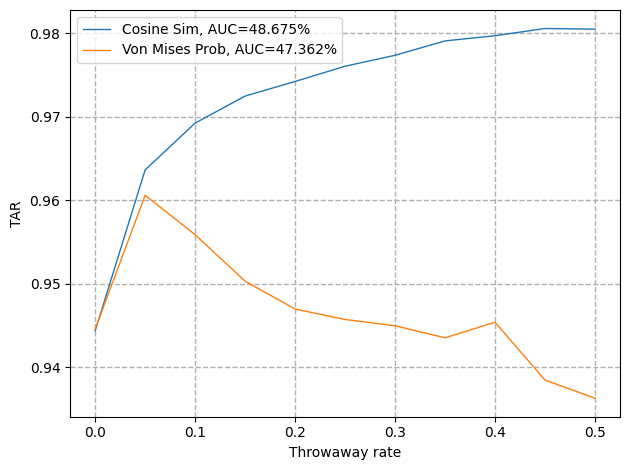

In [58]:
from evaluation.visualize import plot_rejection_scores
scores = [(fractions, scf_tars), (fractions, probe_tars)]
names = ['SCF reject', 'Probe reject']
fig = plot_rejection_scores(
    scores=scores,
    names=model_names,
    y_label=f"TAR",
)
fig.savefig(f"tar_rejection.png", dpi=300)

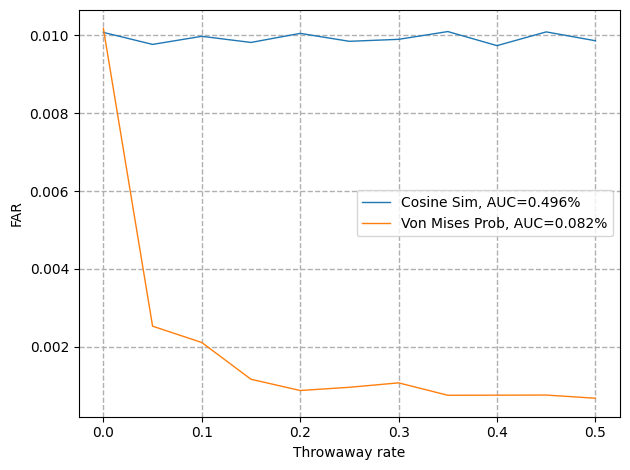

In [59]:
from evaluation.visualize import plot_rejection_scores
scores = [(fractions, scf_fars), (fractions, probe_fars)]
names = ['SCF reject', 'Probe reject']
fig = plot_rejection_scores(
    scores=scores,
    names=model_names,
    y_label=f"FAR",
)
fig.savefig(f"far_rejection.png", dpi=300)

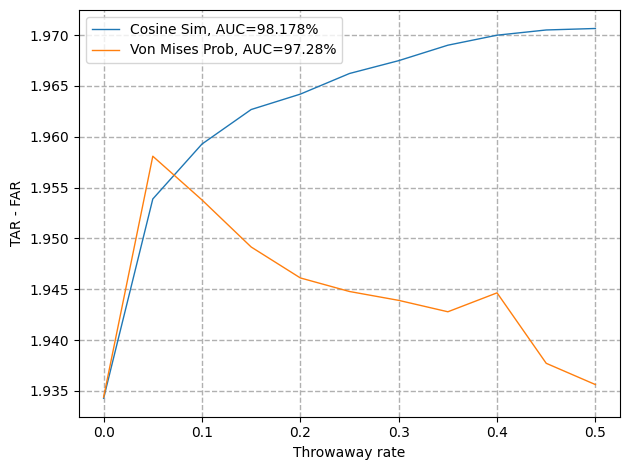

In [63]:
from evaluation.visualize import plot_rejection_scores
scores = [(fractions, scf_tars + (1 - scf_fars)), (fractions, probe_tars + (1-probe_fars))]
names = ['SCF reject', 'Probe reject']
fig = plot_rejection_scores(
    scores=scores,
    names=model_names,
    y_label=f"TAR - FAR",
)
fig.savefig(f"tar_far_rejection.png", dpi=300)